In [1]:
import sys
import os
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from torchinfo import summary
from torchviz import make_dot

# Ensure repository_root_directory is in sys.path if needed
repository_root_directory = os.path.dirname(os.getcwd())
if repository_root_directory not in sys.path:
    sys.path.append(repository_root_directory)

In [2]:
# Load the dataset
data = np.load(os.path.join(repository_root_directory, "_03_extracted_features_cnn.npz"))

features = data["data"]   # shape: (N, H, W, C) (number of samples, height, width, channel)
labels = data["labels"]   # shape: (N,)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Convert labels to int64 (as required by PyTorch CrossEntropyLoss)
labels = labels.astype(np.int64)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Setting Device to:", device)


Features shape: (13990, 150, 150, 1)
Labels shape: (13990,)
X_train shape: (12591, 150, 150, 1)
X_test shape: (1399, 150, 150, 1)
Y_train shape: (12591,)
Y_test shape: (1399,)
Setting Device to: cuda:0


In [3]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.long)
print("X_train_t shape:", X_train_t.shape)
print("Y_train_t shape:", Y_train_t.shape)
print("X_test_t shape:", X_test_t.shape)
print("Y_test_t shape:", Y_test_t.shape)

X_train_t shape: torch.Size([12591, 150, 150, 1])
Y_train_t shape: torch.Size([12591])
X_test_t shape: torch.Size([1399, 150, 150, 1])
Y_test_t shape: torch.Size([1399])


In [4]:
# Create DataLoaders for training and validation
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=32, shuffle=False)
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of samples in train_loader:", len(train_loader.dataset))
print("Number of samples in val_loader:", len(val_loader.dataset))

Number of batches in train_loader: 394
Number of batches in val_loader: 44
Number of samples in train_loader: 12591
Number of samples in val_loader: 1399


In [5]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_shape=(150, 150, 1), num_classes=10):
        super(CNNModel, self).__init__()
        in_channels = input_shape[2]

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # After dimension calculations for input 150x150:
        # Final feature map size after all pooling and convs is (512, 2, 2)
        # Flattened size = 512 * 2 * 2 = 2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1200),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(1200, num_classes)
        )

    def forward(self, x):
        # x: (N, H, W, C) -> permute to (N, C, H, W)
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = self.classifier(x)
        return x

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = CNNModel(input_shape, num_classes=10).to(device)
dummy_input = torch.randn(1, 150, 150, 1).to(device)  # single example
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 32, 150, 150]         320
│    └─ReLU: 2-2                         [1, 32, 150, 150]         --
│    └─Conv2d: 2-3                       [1, 32, 148, 148]         9,248
│    └─ReLU: 2-4                         [1, 32, 148, 148]         --
│    └─MaxPool2d: 2-5                    [1, 32, 74, 74]           --
│    └─Conv2d: 2-6                       [1, 64, 74, 74]           18,496
│    └─ReLU: 2-7                         [1, 64, 74, 74]           --
│    └─Conv2d: 2-8                       [1, 64, 72, 72]           36,928
│    └─ReLU: 2-9                         [1, 64, 72, 72]           --
│    └─MaxPool2d: 2-10                   [1, 64, 36, 36]           --
│    └─Conv2d: 2-11                      [1, 128, 36, 36]          73,856

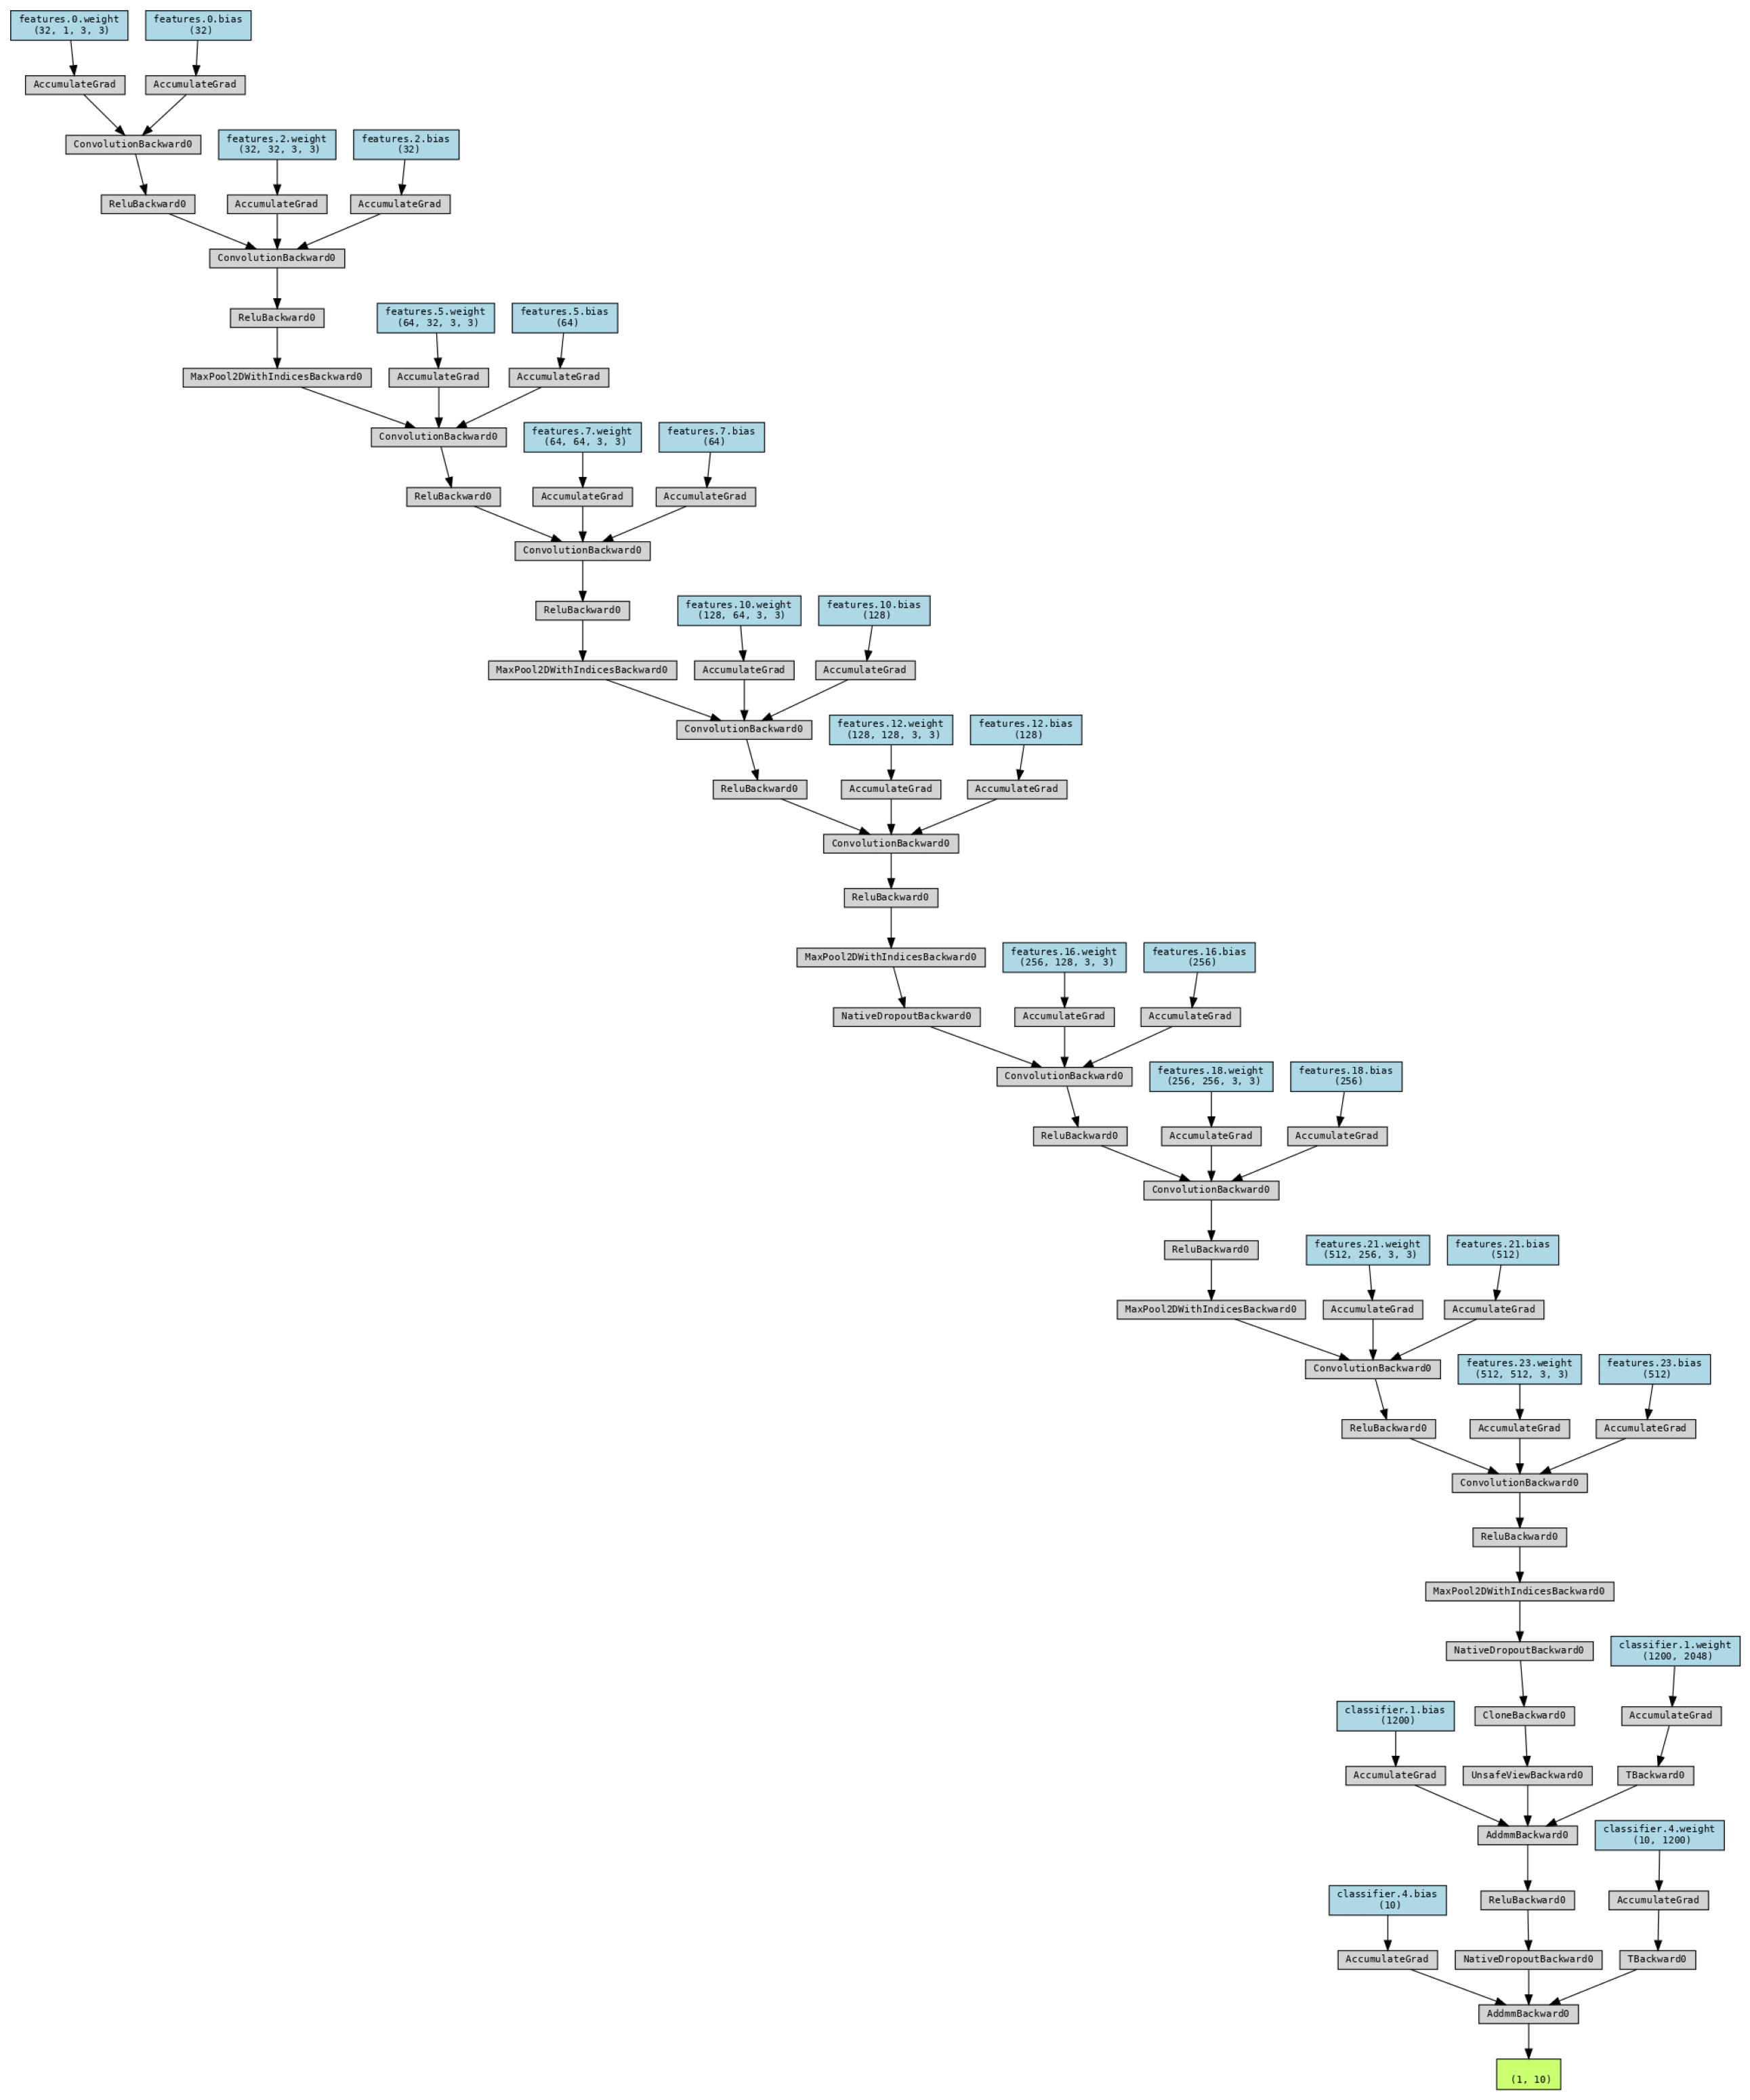

In [6]:
# model architecture
output = model(dummy_input)

# Create a visualization
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")

# visualize the model architecture
plt.figure(figsize=(40, 40))
img = plt.imread("model_architecture.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [8]:
# Training loop - batch size of 32
epochs = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += Y_batch.size(0)
        correct_train += (predicted == Y_batch).sum().item()

    epoch_train_loss = running_loss/len(train_loader.dataset)
    epoch_train_acc = correct_train/total_train

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_val, Y_val in val_loader:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            outputs = model(X_val)
            loss = criterion(outputs, Y_val)

            running_val_loss += loss.item() * X_val.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += Y_val.size(0)
            correct_val += (predicted == Y_val).sum().item()

    epoch_val_loss = running_val_loss/len(val_loader.dataset)
    epoch_val_acc = correct_val/total_val

    training_loss.append(epoch_train_loss)
    training_accuracy.append(epoch_train_acc)
    validation_loss.append(epoch_val_loss)
    validation_accuracy.append(epoch_val_acc)

    print(f"Epoch [{epoch}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.4f}")

Epoch [1/50], Train Loss: 1.7879, Train Acc: 30.5139, Val Loss: 1.4317, Val Acc: 47.1051
Epoch [2/50], Train Loss: 1.3331, Train Acc: 50.7664, Val Loss: 1.0628, Val Acc: 61.4010
Epoch [3/50], Train Loss: 1.0125, Train Acc: 64.3237, Val Loss: 1.0049, Val Acc: 66.6190
Epoch [4/50], Train Loss: 0.7841, Train Acc: 73.3302, Val Loss: 0.6546, Val Acc: 77.9128
Epoch [5/50], Train Loss: 0.6204, Train Acc: 78.9770, Val Loss: 0.5892, Val Acc: 79.6283
Epoch [6/50], Train Loss: 0.5319, Train Acc: 82.1857, Val Loss: 0.5119, Val Acc: 83.6312
Epoch [7/50], Train Loss: 0.4361, Train Acc: 85.6802, Val Loss: 0.4979, Val Acc: 83.9886
Epoch [8/50], Train Loss: 0.3482, Train Acc: 88.3091, Val Loss: 0.4376, Val Acc: 84.6319
Epoch [9/50], Train Loss: 0.3264, Train Acc: 88.7777, Val Loss: 0.4649, Val Acc: 85.0608
Epoch [10/50], Train Loss: 0.2631, Train Acc: 91.1365, Val Loss: 0.3935, Val Acc: 88.8492
Epoch [11/50], Train Loss: 0.2375, Train Acc: 92.0578, Val Loss: 0.3191, Val Acc: 89.7784
Epoch [12/50], Trai

In [9]:
# Evaluate on training set in batches to avoid OOM
eval_batch_size = 32
train_eval_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=eval_batch_size, shuffle=False)
test_eval_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=eval_batch_size, shuffle=False)

model.eval()
train_loss_eval = 0.0
train_correct = 0
train_total = 0
with torch.no_grad():
    for Xb, Yb in train_eval_loader:
        Xb = Xb.to(device)
        Yb = Yb.to(device)
        outputs = model(Xb)
        loss = criterion(outputs, Yb)
        train_loss_eval += loss.item() * Xb.size(0)
        _, pred = torch.max(outputs, 1)
        train_correct += (pred == Yb).sum().item()
        train_total += Yb.size(0)

final_train_loss = train_loss_eval / train_total
final_train_acc = train_correct / train_total
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_acc*100)

model.eval()
test_loss_eval = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for Xb, Yb in test_eval_loader:
        Xb = Xb.to(device)
        Yb = Yb.to(device)
        outputs = model(Xb)
        loss = criterion(outputs, Yb)
        test_loss_eval += loss.item() * Xb.size(0)
        _, pred = torch.max(outputs, 1)
        test_correct += (pred == Yb).sum().item()
        test_total += Yb.size(0)

final_test_loss = test_loss_eval / test_total
final_test_acc = test_correct / test_total
print("Final Validation Loss:", final_test_loss)
print("Final Validation Accuracy:", final_test_acc*100)

Final Training Loss: 0.022757378623781268
Final Training Accuracy: 99.20578190771185
Final Validation Loss: 0.3073929873554088
Final Validation Accuracy: 93.85275196568978


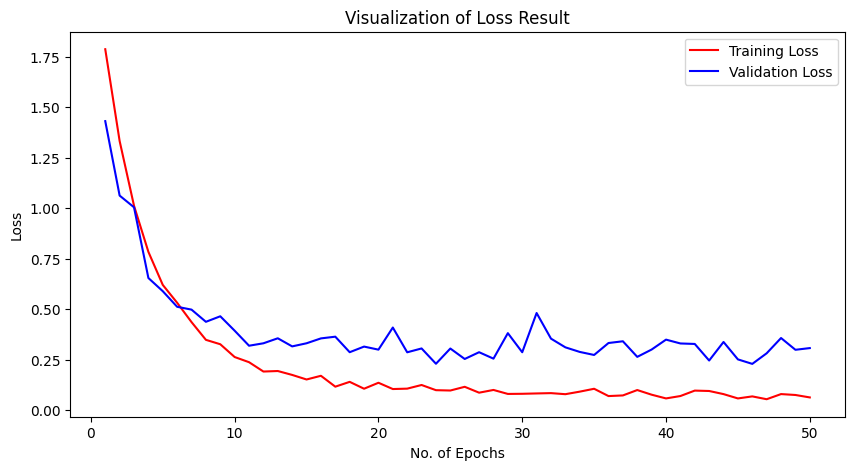

In [10]:
# Visualization of Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), training_loss, label="Training Loss", color='red')
plt.plot(range(1, epochs+1), validation_loss, label="Validation Loss", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

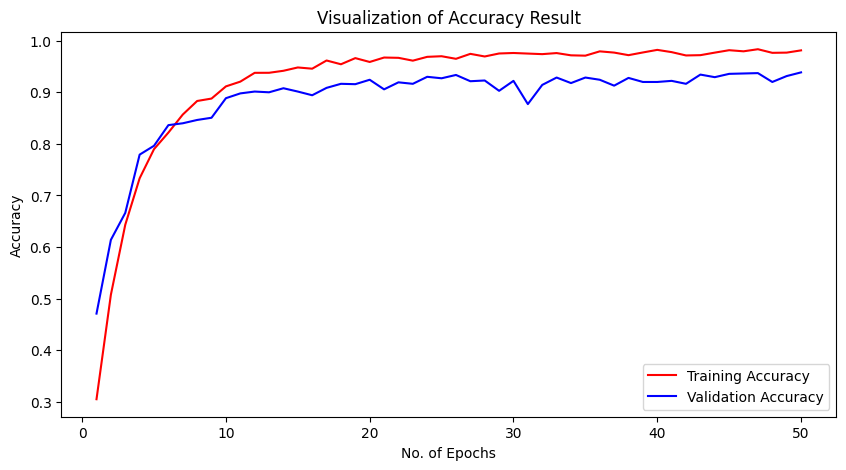

In [11]:
# Visualization of Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), training_accuracy, label="Training Accuracy", color='red')
plt.plot(range(1, epochs+1), validation_accuracy, label="Validation Accuracy", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [12]:
# Save the model
torch.save(model.state_dict(), "cnn_model.h5")


In [ ]:
# Load the model
loaded_model = torch.load("cnn_model.h5")
print(loaded_model)

OrderedDict([('features.0.weight', tensor([[[[-2.5289e-02, -7.3302e-02,  2.3558e-01],
          [-2.2604e-01,  4.8915e-02, -2.5911e-01],
          [ 1.3207e-01, -4.5504e-04,  9.5672e-02]]],


        [[[-8.0560e-03, -1.9184e-01,  2.9162e-01],
          [-3.9893e-01, -1.2804e-01, -6.2794e-02],
          [-2.2123e-01, -2.3356e-01,  2.3540e-01]]],


        [[[-2.8760e-01,  2.1188e-01,  1.3267e-01],
          [ 1.6625e-01,  1.6913e-01,  2.5380e-02],
          [-2.2018e-01,  5.2172e-02,  4.1910e-02]]],


        [[[-3.3161e-01, -2.1815e-01, -3.3660e-02],
          [-1.2950e-01, -1.6696e-02,  2.6543e-01],
          [ 2.2670e-01, -1.7879e-01, -1.7929e-01]]],


        [[[-1.8870e-01,  1.2379e-01,  1.7790e-01],
          [-2.7347e-01,  6.1153e-02, -1.8577e-01],
          [ 1.4542e-01, -8.7660e-02, -4.1144e-04]]],


        [[[ 2.5057e-02, -3.6469e-01, -1.4514e-01],
          [-2.9119e-01,  1.0928e-01,  1.8535e-01],
          [-5.5069e-02,  1.9324e-01, -1.2653e-01]]],


        [[[-2.4754e-01,